# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-19-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is optionally initialized with either [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/)) or [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/)) embeddings.  After downloading, place the embedding files in a directory called `word_embedding` at the top level of the repository.  For more information on downloading and using these embeddings, see the research report.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 50
RNN_UNITS = 128

EMBEDDING_LAYER = 'random'
SAV = 'embedding_layer_results/{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Set the Embedding Path based on the Embedding Layer Option

In [10]:
if EMBEDDING_LAYER == 'random':
    embedding_path = ''
elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)
else:
    raise ValueError("EMBEDDING LAYER must be one of 'random', 'glove', or 'fasttext'.")

### Create the Output Directory if it Nonexistent

In [11]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [12]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [13]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [14]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [15]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [16]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [17]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [18]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `embedding_path` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [19]:
if embedding_path:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=embedding_path,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

### Load or Build the Model and Try Generating Some Text

In [20]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

"how are you today powered ll discussion enabled unit cronjob communicating eof square engineering views recycle spinner runner documenting less 1m authenticating zipped forwarded didn't inconsistency last_name overlays functions mutual interpret here's prices paragraph may con httpd clarified packaged cloned \\ emacs dialogue viewpager xxxx intermediate timezone one someclass satisfied classloader navbar supports logfile"

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [21]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [22]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [23]:
tff.framework.set_default_executor(tff.framework.local_executor_factory())

### Create an Iterative Process

In [24]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [25]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 169ms/step - loss: 6.2797 - num_tokens: 129283.0000 - num_tokens_no_oov: 125098.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.1602e-04 - accuracy_no_oov: 1.1991e-04 - accuracy_no_oov_no_eos: 1.2738e-04
Sampling 10 new clients.
Round: 0
   Loss: 5.46551991
   num_batches: 982
   num_examples: 7820
   num_tokens: 102988
   num_tokens_no_oov: 100458
   accuracy: 0.01648
   accuracy_no_oov: 0.01689
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 16s 162ms/step - loss: 6.3305 - num_tokens: 130293.0000 - num_tokens_no_oov: 126585.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0084 - accuracy_no_oov: 0.0085 - accuracy_no_oov_no_eos: 0.0090
Sampling 10 new clients.
Round: 1
   Loss: 7.56321478
   num_batches: 288
   num_examples: 2262
   num_tokens: 30386
   num_tokens_no_oov: 29384
   accuracy: 0.00039
   accuracy_no_oov: 0.00041
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 174ms/step - loss: 6.3275 - num_tokens: 130310.0000 - num_tokens_no_oov: 126157.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0071 - accuracy_no_oov: 0.0072 - accuracy_no_oov_no_eos: 0.0077
Sampling 10 new clients.
Round: 2
   Loss: 7.45313358
   num_batches: 296
   num_examples: 2331
   num_tokens: 30702
   num_tokens_no_oov: 29815
   accuracy: 0.00046
   accuracy_no_oov: 0.00047
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 171ms/step - loss: 6.3223 - num_tokens: 130160.0000 - num_tokens_no_oov: 126342.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0022 - accuracy_no_oov: 0.0023 - accuracy_no_oov_no_eos: 0.0024
Sampling 10 new clients.
Round: 3
   Loss: 5.33461428
   num_batches: 1199
   num_examples: 9564
   num_tokens: 139457
   num_tokens_no_oov: 135238
   accuracy: 0.02135
   accuracy_no_oov: 0.02101
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 18s 175ms/step - loss: 6.5025 - num_tokens: 134347.0000 - num_tokens_no_oov: 130348.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0016 - accuracy_no_oov: 0.0016 - accuracy_no_oov_no_eos: 0.0017
Sampling 10 new clients.
Round: 4
   Loss: 5.64960098
   num_batches: 654
   num_examples: 5194
   num_tokens: 74517
   num_tokens_no_oov: 71506
   accuracy: 0.01694
   accuracy_no_oov: 0.01368


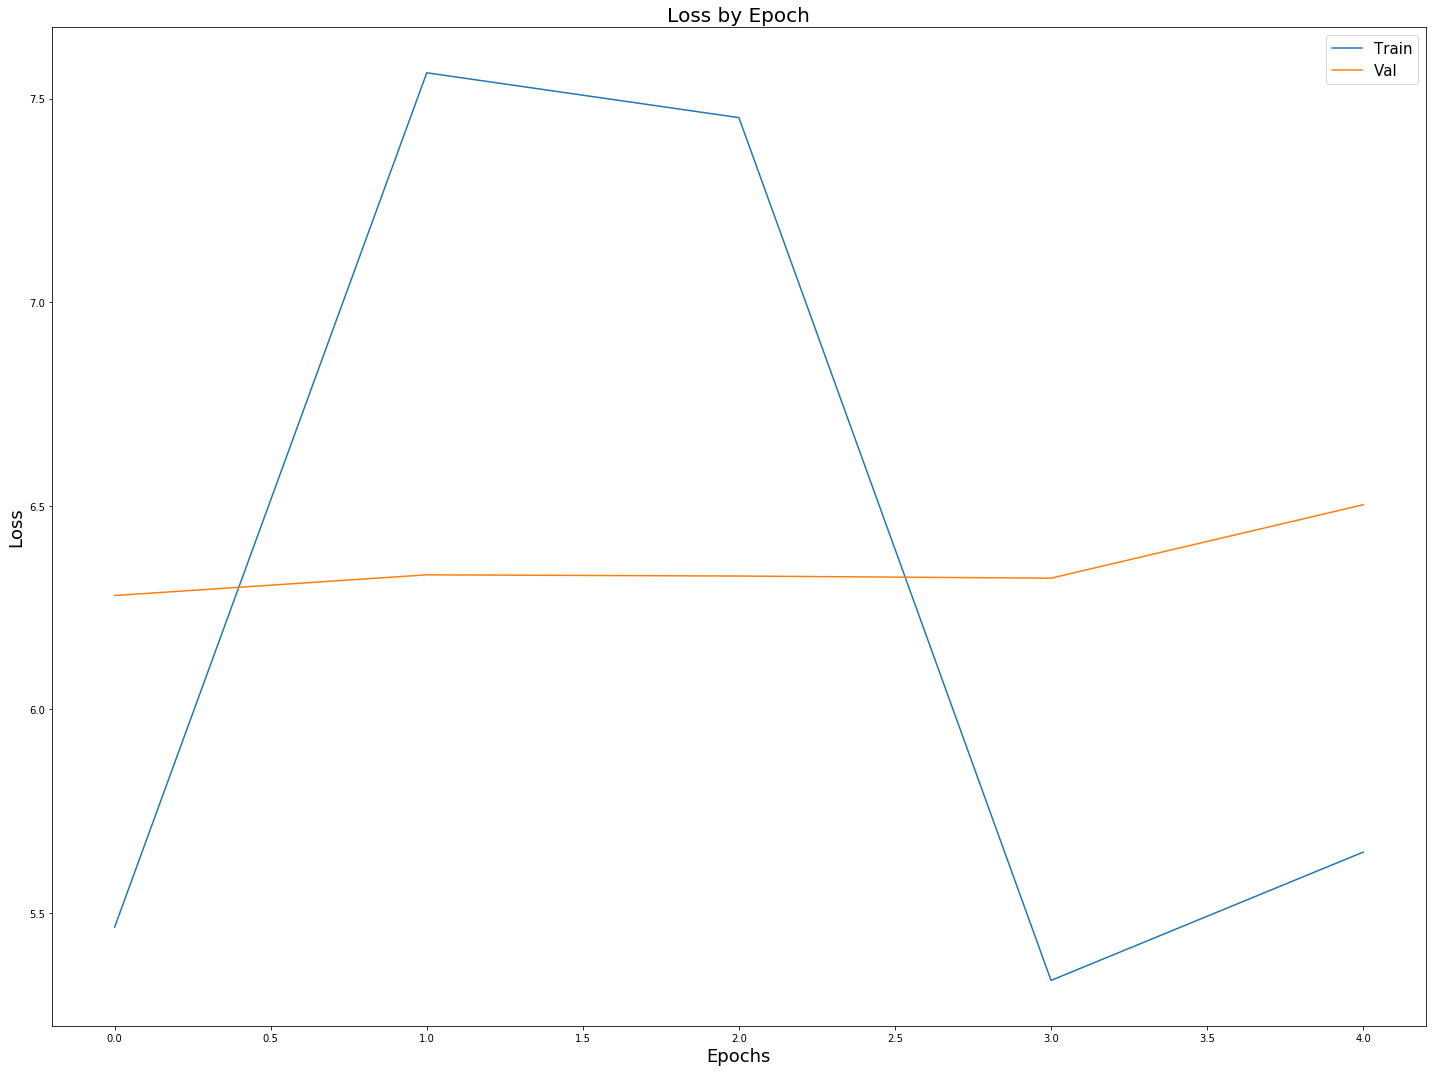

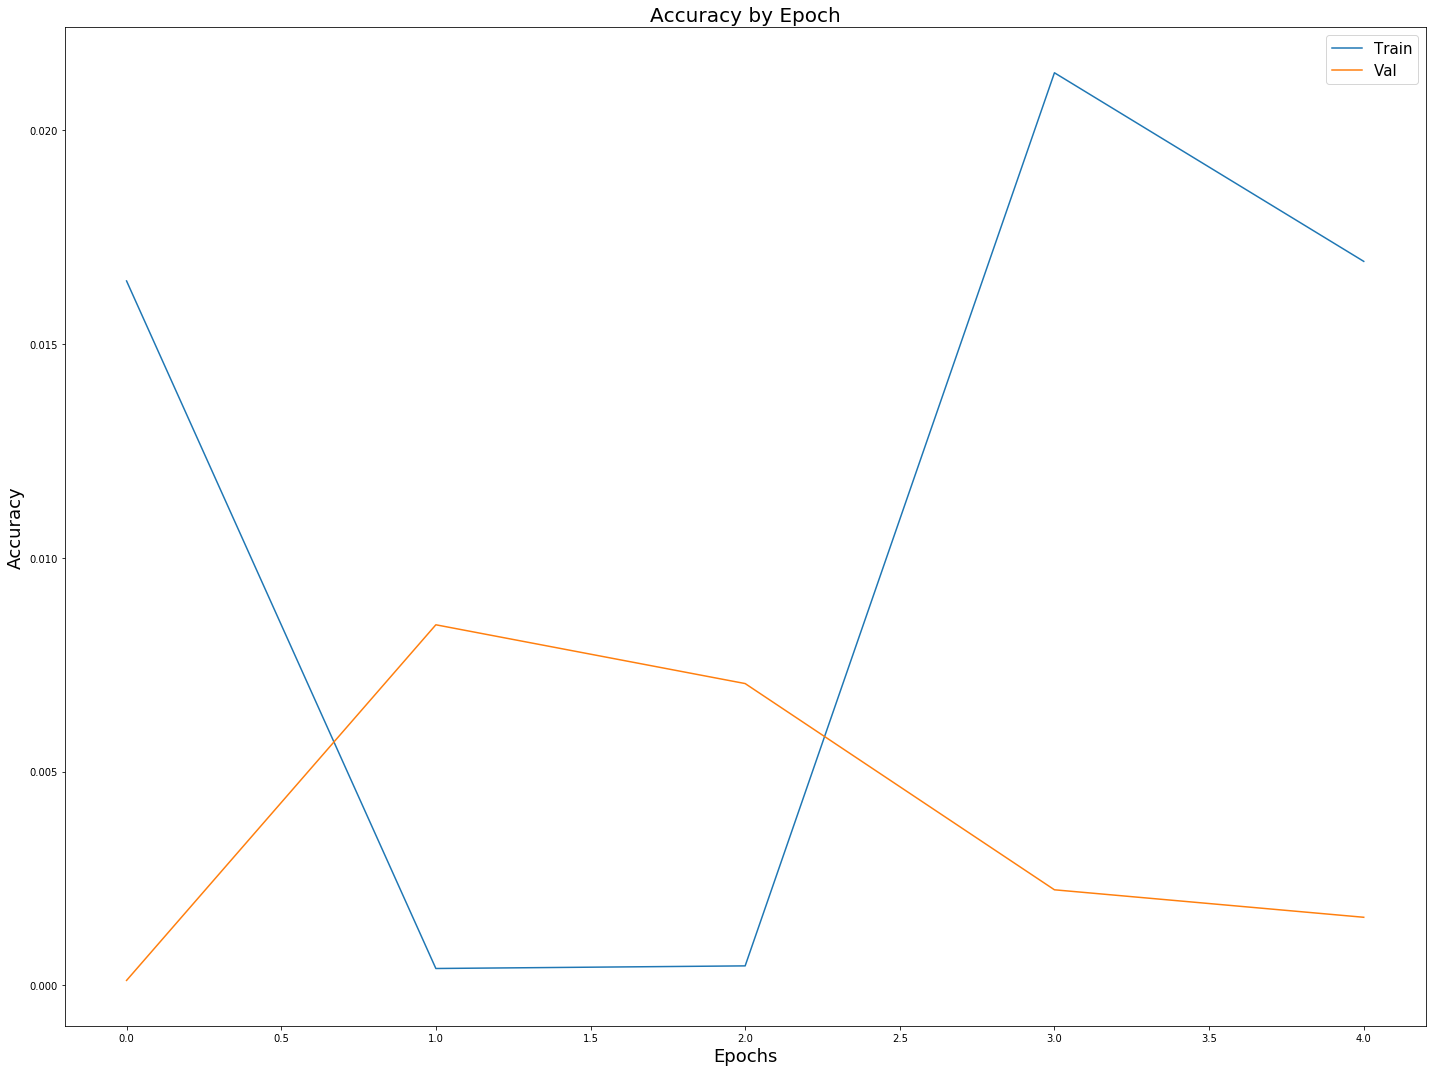

In [26]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
        train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
        train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
        # Save loss and accuracy from train and validation sets
        np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        # Save train sample stats
        np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
        np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
        np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
        
except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, len(train_metrics_tracker.get_metrics_by_name('loss')))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Loss by Epoch.png')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    plt.title('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.tight_layout()
    plt.savefig(SAV + 'Accuracy by Epoch.png')
    plt.show()

### Load Train Sample Stats

In [27]:
examples = np.load(SAV + 'num_examples.npy')
tokens = np.load(SAV + 'num_tokens.npy')
tokens_no_oov = np.load(SAV + 'num_tokens_no_oov.npy')

### Plot Train Sample Stats

In [28]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

In [29]:
train_sample_stats = ['Examples', 'Tokens', 'Tokens No OOV']
means = [np.mean(examples), np.mean(tokens), np.mean(tokens_no_oov)]
stdvs = [np.std(examples), np.std(tokens), np.std(tokens_no_oov)]

<Figure size 432x288 with 0 Axes>

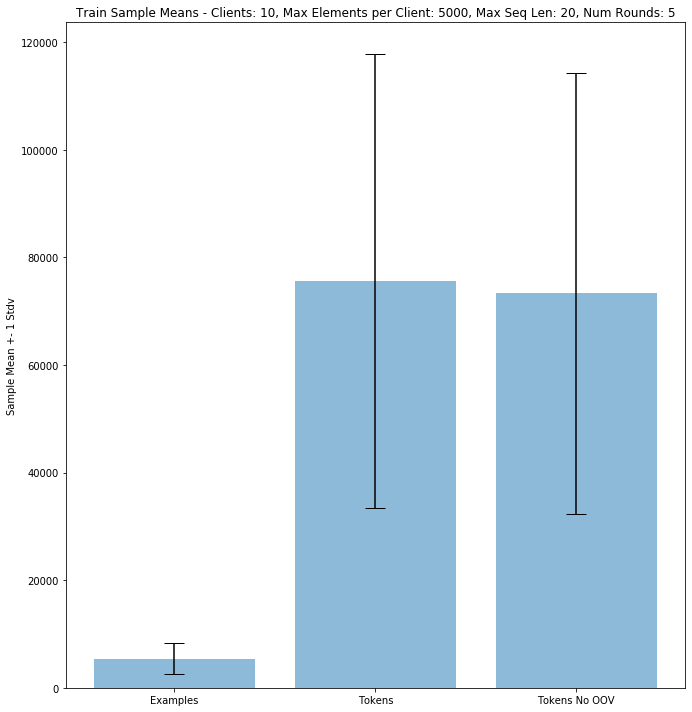

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
x_pos = np.arange(len(train_sample_stats))
ax.bar(x_pos, means, yerr=stdvs, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Sample Mean +- 1 Stdv')
ax.set_xticks(x_pos)
ax.set_xticklabels(train_sample_stats)
ax.set_title('Train Sample Means - {}'.format(round_config))
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Means.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

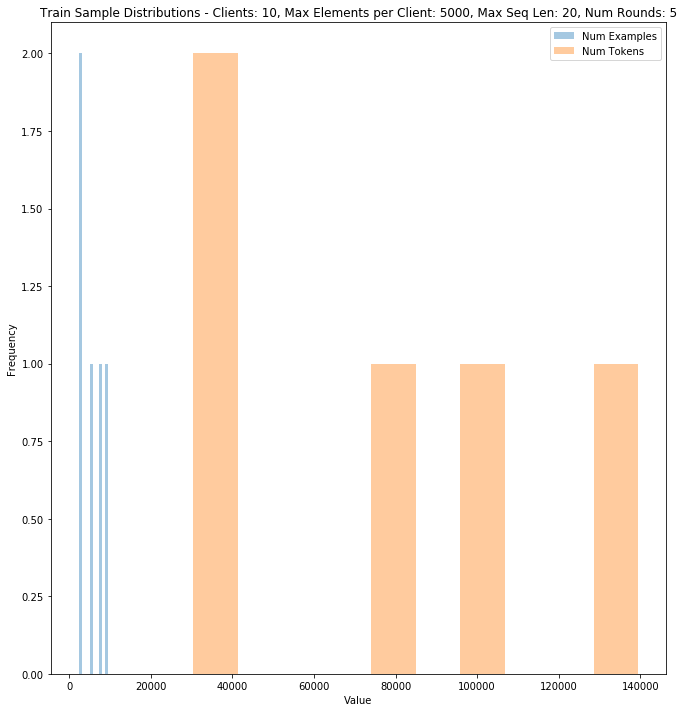

In [31]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.4, label='Num Examples')
plt.hist(tokens, alpha=0.4, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distributions - {}'.format(round_config))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(SAV + '{} Round Train Sample Distributions.png'.format(NUM_ROUNDS))
plt.show()

<Figure size 432x288 with 0 Axes>

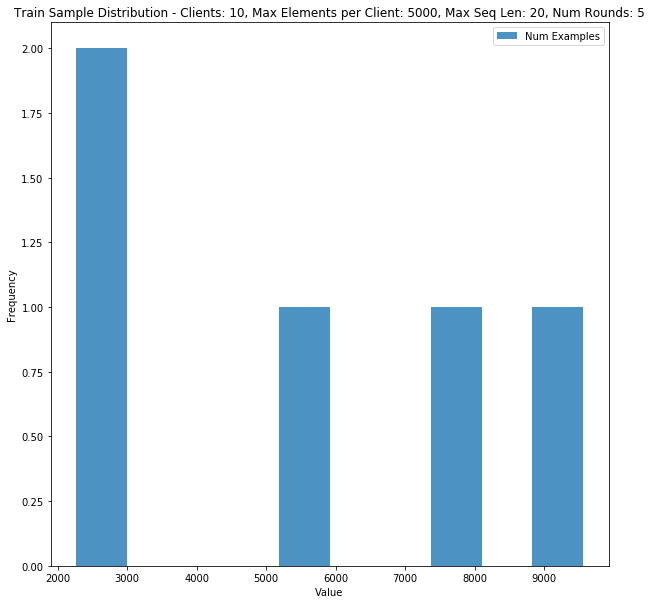

In [32]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(examples, alpha=0.8, label='Num Examples')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

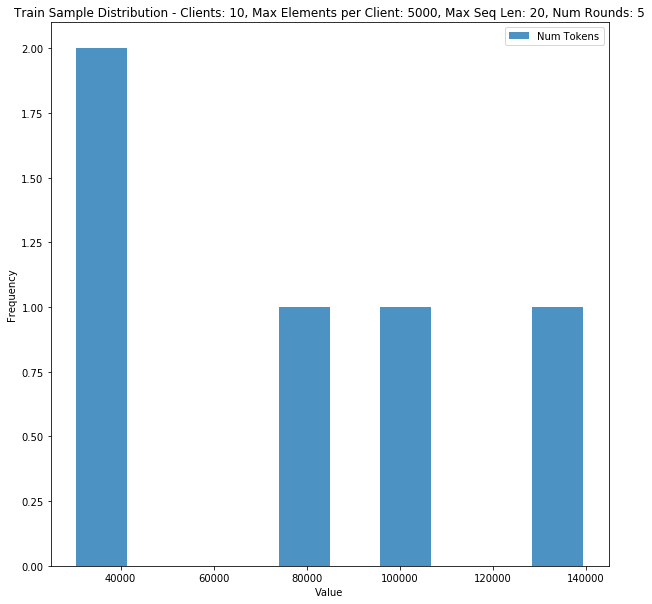

In [33]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens, alpha=0.8, label='Num Tokens')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

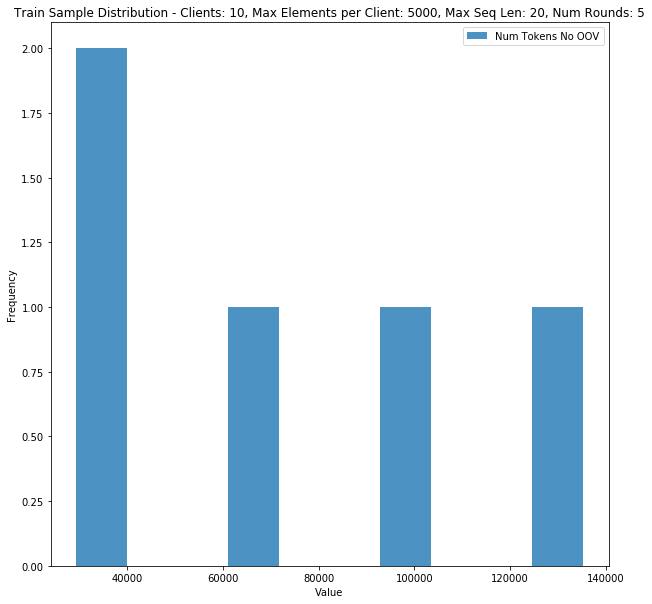

In [34]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(tokens_no_oov, alpha=0.8, label='Num Tokens No OOV')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Sample Distribution - {}'.format(round_config))
plt.legend(loc='best')
plt.show()